In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from catboost import CatBoostClassifier, CatBoostRegressor

from mofapy2.run.entry_point import entry_point
import h5py

import sys
sys.path.append("..")

from src.tcga_preprocess_utils import handle_duplicates, prepare_data, choose_common_patients
from src.mofa_utils import transform_df_for_mofa, preprocess_data_for_mofa

In [2]:
RANDOM_STATE = 42

Выживаемость:

In [3]:
survival_data = pd.read_csv('data/breast/survival', sep='\t')
survival_data['PatientID'] = survival_data['PatientID'].str.lower()

survival_data = handle_duplicates(survival_data)
survival_data = survival_data.dropna(subset=['Death'])
survival_data = survival_data.set_index('PatientID')

survival_data

,Survival,Death
PatientID,,
tcga.ol.a66h,812.0,0.0
tcga.3c.aalk,1448.0,0.0
tcga.ar.a1ah,3807.0,0.0
tcga.ac.a5eh,511.0,0.0
tcga.ew.a2fw,672.0,0.0
...,...,...
tcga.e9.a3ho,1158.0,0.0
tcga.d8.a27e,530.0,0.0
tcga.ar.a24q,3172.0,0.0


In [4]:
expression_data = prepare_data('data/breast/exp', survival_data.index)
expression_data = preprocess_data_for_mofa(expression_data)

methylation_data = prepare_data('data/breast/methy', survival_data.index)
methylation_data = preprocess_data_for_mofa(methylation_data)

mirna_data = prepare_data('data/breast/mirna', survival_data.index)
mirna_data = preprocess_data_for_mofa(mirna_data)

*Теперь во всех оставляем только пациентов, встречающихся во всех 4х датасетах*

In [5]:
survival_data, expression_data, methylation_data, mirna_data = choose_common_patients(
    survival_data, expression_data, methylation_data, mirna_data)


target_death= survival_data['Death']
target_survival = survival_data['Survival']

In [6]:
print('Всего пациентов: ', expression_data.shape[0])

Всего пациентов:  620


MOFA

Преобразовываем под нужный формат данных, нормализуем

In [7]:
transformed_expression_data = transform_df_for_mofa(expression_data.copy(), 'DNA')
transformed_methylation_data = transform_df_for_mofa(methylation_data.copy(), 'Methylation')
transformed_mirna_data = transform_df_for_mofa(mirna_data.copy(), 'RNA')

combined_data = pd.concat([transformed_expression_data, transformed_methylation_data, transformed_mirna_data], axis=0)

scaler = MinMaxScaler()
combined_data['value'] = scaler.fit_transform(combined_data[['value']])


combined_data

,sample,feature,value,view
0,tcga.3c.aaau,?|10357,0.059777,DNA
1,tcga.3c.aali,?|10357,0.067703,DNA
2,tcga.3c.aalj,?|10357,0.105768,DNA
3,tcga.3c.aalk,?|10357,0.101071,DNA
4,tcga.4h.aaak,?|10357,0.074213,DNA
...,...,...,...,...
112835,tcga.wt.ab44,hsa-mir-99a,0.098390,RNA
112836,tcga.xx.a899,hsa-mir-99a,0.125517,RNA
112837,tcga.xx.a89a,hsa-mir-99a,0.105323,RNA
112838,tcga.z7.a8r5,hsa-mir-99a,0.099055,RNA


Обучаем модель

In [8]:
ent = entry_point()


# (2) Set data options
# - scale_views: if views have very different ranges, one can to scale each view to unit variance
ent.set_data_options(
    scale_views=False
)

# (3) Set data using the data frame format
ent.set_data_df(combined_data)

# using default values
ent.set_model_options()

# using personalised values
ent.set_model_options(
    factors=10,
    spikeslab_weights=True,
    ard_weights=True
)

## (5) Set training options ##
# - iter: number of iterations
# - convergence_mode: "fast", "medium", "slow". Fast mode is usually good enough.
# - dropR2: minimum variance explained criteria to drop factors while training. Default is None, inactive factors are not dropped during training
# - gpu_mode: use GPU mode? this functionality needs cupy installed and a functional GPU, see https://biofam.github.io/MOFA2/gpu_training.html
# - seed: random seed

# using default values
ent.set_train_options()

# using personalised values
ent.set_train_options(
    iter=5000,
    convergence_mode="slow",
    dropR2=None,
    gpu_mode=False,
    seed=RANDOM_STATE
)

####################################
## Build and train the MOFA model ##
####################################

# Build the model
ent.build()

# Run the model
ent.run()

####################
## Save the model ##
####################

outfile = f"data/outputs/test_{time.time()}.hdf5"

# - save_data: logical indicating whether to save the training data in the hdf5 file.
# this is useful for some downstream analysis in R, but it can take a lot of disk space.
ent.save(outfile, save_data=True)

#########################
## Downstream analysis ##
#########################

# Check the mofax package for the downstream analysis in Python: https://github.com/bioFAM/mofax
# Check the MOFA2 R package for the downstream analysis in R: https://www.bioconductor.org/packages/release/bioc/html/MOFA2.html
# All tutorials: https://biofam.github.io/MOFA2/tutorials.html

# Extract factor values (a list with one matrix per sample group)
factors = ent.model.nodes["Z"].getExpectation()

# Extract weights  (a list with one matrix per view)
weights = ent.model.nodes["W"].getExpectation()

# Extract variance explained values
r2 = ent.model.calculate_variance_explained()

# Interact directly with the hdf5 file

# f = h5py.File(outfile, 'r')


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='DNA' with N=620 samples and D=1281 features...
Loaded group='single_group' view='Methylation' with N=620 samples and D=1149 features...
Loaded group='single_group' view='RNA' with N=620 samples and D=182 features...


Model options:
- Automatic Relevan

Посмотрим как хорошо различаются факторы

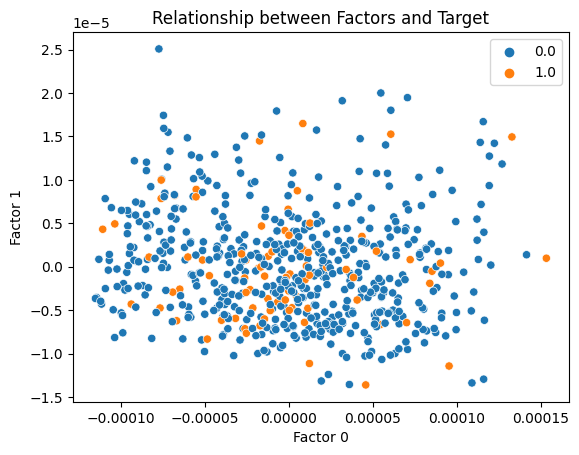

In [9]:
sns.scatterplot(x=factors[:, 0], y= factors[:, 1], hue=target_death.values)
plt.title('Relationship between Factors and Target')
plt.xlabel('Factor 0')
plt.ylabel('Factor 1');

Посмотрим можно ли предсказать смерть с помощью факторов

In [10]:
X_train, X_test, y_train, y_test = train_test_split(factors, target_death, test_size=0.25, random_state=RANDOM_STATE, stratify=target_death)

In [11]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.8709677419354839, F1: 0.0


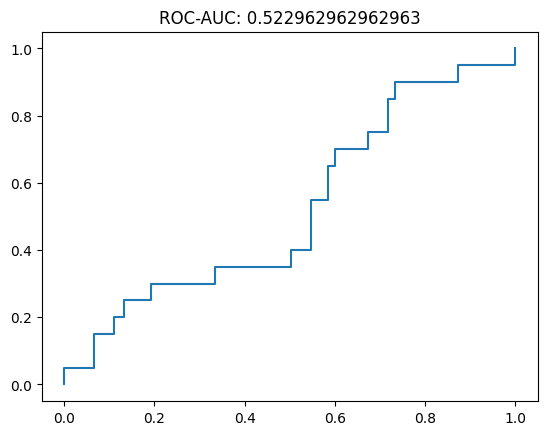

In [13]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {roc_auc}');